<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/82_%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8B%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
import nltk
import pandas as pd
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


!python --version
!pip show google tensorflow nltk pandas

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/06.MachineLearning/'
max_len = 0
vocabulary = []

In [ ]:
def read_dataset(type_):
    global max_len
    global vocabulary
    df = pd.read_table(BASE_PATH+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    max_len_ = df['title'].map(lambda x: len(x.split())).max()
    if max_len < max_len_:
        max_len = max_len_
    if len(vocabulary) == 0:
        vocabulary = [k for k, v in nltk.FreqDist(sr_title).items() if v > 1]
    else:
        vocabulary.extend([k for k, v in nltk.FreqDist(sr_title).items() if v > 1])
    y = df['category'].replace({'b':0, 't':1, 'e':2, 'm':3})
    return df['title'], tf.keras.utils.to_categorical(y, dtype='int32')  # 4値分類なので訓練・検証・テスト共通でone-hot化

In [ ]:
X_train, y_train = read_dataset('train')
X_valid, y_valid = read_dataset('valid')
X_test, y_test = read_dataset('test') # あまりこだわらずにテストデータセットも追加

# setで重複削除し、タプル形式に設定
tup_voc = tuple(set(vocabulary))

print(f'vocabulary size before removing duplicates: {len(vocabulary)}')
print(f'vocabulary size after removing duplicates: {len(tup_voc)}')
print(f'sample vocabulary: {tup_voc[:10]}')
print(f'max length is {max_len}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
vocabulary size before removing duplicates: 11089
vocabulary size after removing duplicates: 7802
sa

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 output_mode='int',
 vocabulary=tup_voc,
 output_sequence_length=max_len)

['', '[UNK]', 'Worth', 'believe', 'swipe', 'officially', 'George', 'fiber', 'carpet', 'Rumor']


In [ ]:
#https://www.tensorflow.org/text/guide/word_embeddings

# embeddingのデフォルトinitializerであるuniformはrandom_uniform
# https://github.com/keras-team/keras/blob/v2.7.0/keras/initializers/__init__.py#L116

# cuDNN を使うようにGRUは基本はデフォルト値
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(vectorize_layer.vocabulary_size()+1, 300, mask_zero=True))
model.add(tf.keras.layers.GRU(50))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 300)           2341500   
                                                                 
 gru (GRU)                   (None, 50)                52800     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 2,394,504
Trainable params: 2,394,504
Non-trainable params: 0
_________________________________________________________________


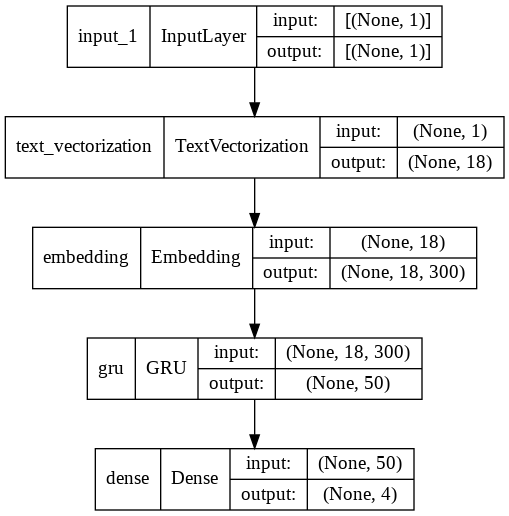

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
334/334 [==============================] - 15s 29ms/step - loss: 1.2011 - acc: 0.4497 - val_loss: 1.1557 - val_acc: 0.4708
Epoch 2/10
334/334 [==============================] - 8s 25ms/step - loss: 1.1507 - acc: 0.4777 - val_loss: 1.1493 - val_acc: 0.4925
Epoch 3/10
334/334 [==============================] - 8s 24ms/step - loss: 1.1445 - acc: 0.4891 - val_loss: 1.1429 - val_acc: 0.4880
Epoch 4/10
334/334 [==============================] - 8s 24ms/step - loss: 1.1383 - acc: 0.4912 - val_loss: 1.1382 - val_acc: 0.4888
Epoch 5/10
334/334 [==============================] - 8s 24ms/step - loss: 1.1321 - acc: 0.4982 - val_loss: 1.1320 - val_acc: 0.4970
Epoch 6/10
334/334 [==============================] - 8s 24ms/step - loss: 1.1248 - acc: 0.5053 - val_loss: 1.1248 - val_acc: 0.5037
Epoch 7/10
334/334 [==============================] - 8s 24ms/step - loss: 1.1156 - acc: 0.5160 - val_loss: 1.1140 - val_acc: 0.5262
Epoch 8/10
334/334 [==============================] - 8s 24ms/step -

In [ ]:
model.evaluate(X_test, y_test)

42/42 [==============================] - 0s 7ms/step - loss: 1.0089 - acc: 0.6213


[1.0088515281677246, 0.621257483959198]